In [ ]:
import os 
import music21 as m21
from music21 import midi, converter
import unittest
import random
import json 
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install visual_midi
!pip install pretty_midi
from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI
drive.mount('/content/drive/')
code_path = '/content/drive/My Drive/melody_generation'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
#make sure you change runtime to GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


**Preprocessing Constants**

In [ ]:
KERN_DATASET_PATH = os.path.join(code_path,"erk/erk")
print(KERN_DATASET_PATH)
ACCEPTABLE_DURATIONS = [0.25,0.5,0.75,1.0,1.5,2,3,4]
SAVE_DIR = os.path.join(code_path,'dataset')
SINGLE_FILE_DATASET = os.path.join(code_path,"file_dataset")
SEQUENCE_LENGTH = 64
MAPPING_PATH = os.path.join(code_path,"vocabulary.json")

/content/drive/My Drive/melody_generation/erk/erk


**Training Constants**

In [ ]:
#corresponds to vocabulary size in training data 
OUTPUT_UNITS = 38
#specifies neuron count in each layer of network, we will only use one LSTM layer w/ 256 neurons
NUM_UNITS = [256]
#loss function
LOSS = "sparse_categorical_crossentropy"
#learning rate
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = os.path.join(code_path,"model_lstm.h5")

# **Preprocessing**
Run this only to load in generate_training_sequences function, training data preprocessed and saved at time of writing 

---



In [ ]:
#m21 can parse kern, MIDI, MusicXML files and convert and revert these files @ will. Represents music in an OOP manner. 
def load_songs_in_kern(dataset_path):
	'''pass in a valid folder path holding all training songs in .krn format converts to m21 
	   and returns list of m21 objects
	'''
	songs = []
	#iterate through all data files  and load w/ music21
	for path, subdir, files in os.walk(dataset_path): 
		#recursively goes through all the files 
		for file in files:
			#load only .krn files
			if file[-3:] == "krn":
				#load w/ music 21, song is a m21 stream (m21 base class)
				try:
					song = m21.converter.parse(os.path.join(path, file))
					songs.append(song)
				except:
					print(file)

	return songs

def has_acceptable_durations(song,acceptable_durations):
	'''expects music21 song object. 
	   Returns True if all notes and rests within song are within predefined definitions for model. 
	'''

	for note in song.flat.notesAndRests:
		if note.duration.quarterLength not in acceptable_durations:
			return False

	return True

def transpose(song):
	'''expects music21 song object
	   returns song tranposed to Cmaj/Amin (depending on song's origin mode) | 
	   Done so generative model does not have to learn all 24 musical keys
	'''

	#get key from song | usually stored @ index 4 of first measure
	parts = song.getElementsByClass(m21.stream.Part) 
	part_0_measure = parts[0].getElementsByClass(m21.stream.Measure)
		#take first measure's 4th element to extract the key 
	key = part_0_measure[0][4]

	#check if key was actually notated in a song or not.
	if not isinstance(key, m21.key.Key):
		#use m21 to estimate the key
		key = song.analyze("key")

	#get interval for transposition | ex: if song is in Bmaj --> Cmaj, we need to transpose song by an interval 
	#check if song is in major or minor
	if key.mode == "major":
		#calculate interval from origin key to destination pitch (C)
		interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))

	elif key.mode == "minor":
		#calculate interval from origin key to destination pitch (A)
		interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

	#tranpose the song by the calculated interval
	transposed_song = song.transpose(interval)
	return transposed_song

def encode_song(song, time_step = 0.25):
	'''
	p = 60, d = 1 -> [60,"_","_","_"]
	expects music21 object
	returns string of time series representation of that object 

	'''
	encoded_song = []

	for event in song.flat.notesAndRests:

		#handle notes
		if isinstance(event, m21.note.Note):
			symbol = event.pitch.midi

		elif isinstance(event, m21.note.Rest):
			symbol = "r"

		#converts symbols into time series notation
		steps = int(event.duration.quarterLength/time_step)
		for step in range(steps):
			if step == 0:
				encoded_song.append(symbol)
			else:
				encoded_song.append("_")

	#convert encoded_song to string form
	encoded_song = " ".join(map(str,encoded_song))

	return encoded_song
			

def preprocess(dataset_path):

	#load the data
	print("Loading songs ... ")
	songs = load_songs_in_kern(dataset_path)
	print(f"{len(songs)} songs loaded")

	for i, song in enumerate(songs):
		#filter out songs which  have non-acceptable durations 
		if not has_acceptable_durations(song,ACCEPTABLE_DURATIONS):
			print("unnacceptable")
			continue

		#transpose all songs to Cmajor/Amin 
		song = transpose(song)

		#encode songs w/ music time series representation
		encoded_song = encode_song(song)

		#save the songs to text file
		file_name = str(i) + "_encoded"
		save_path = os.path.join(SAVE_DIR, file_name)

		with open(save_path,"w") as fp:
			fp.write(encoded_song)

def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

def create_single_file_dataset(dataset_path,file_dataset_path,sequence_length):
	
	new_song_delimiter = "/ " * sequence_length

	songs = ""
	#load encoded songs and add delimiters
	for path, _, folder in os.walk(dataset_path):  #
		for file in folder:
			file_path = os.path.join(path,file)
			song = load(file_path)
			songs = songs + song + " " + new_song_delimiter

	songs = songs[:-1] #remove empty space
	#save the string containing data
	with open(file_dataset_path, "w") as fdp:
		fdp.write(songs)

	return songs 

def create_mapping(songs, mapping_path):

	#define grammar
	mappings = {}

	songs = songs.split()
	vocabulary = list(set(songs))
	for i, symbol in enumerate(vocabulary):
		mappings[symbol] = i 

	#save grammar to JSON
	with open(mapping_path,"w") as mp:
		json.dump(mappings,mp,indent = 4)

def songs_to_int(songs):
	"""
	users vocabulary dictionary to reperesent music notes numerically in a common
	vocabulary per the given dataset
	"""
	int_songs = []
	with open(MAPPING_PATH,"r") as fp:
		mappings = json.load(fp)

	songs = songs.split()
	for symbol in songs:
		int_songs.append(mappings[symbol])

	return int_songs


def generate_training_sequences(sequence_length):
	#preps single file dataset into inputs of one-hot-encoded input vectors and targets

	#load songs and map to int
	songs = load(SINGLE_FILE_DATASET)
	int_songs = songs_to_int(songs)

	#generate inputs + targets for training
	inputs = []
	targets = []
	num_sequences = len(int_songs) - SEQUENCE_LENGTH

	for i in range(num_sequences):
		inputs.append(int_songs[i:i+sequence_length])
		targets.append(int_songs[i+sequence_length])

	#one-hot encode sequences, music notes are not ordinal, so to represent them properly
	#we need to one hot encode and then feed into LSTM
	vocab_size = len(set(int_songs))
	inputs = keras.utils.to_categorical(inputs, 
		num_classes=vocab_size) #turns each input into OHE w/ vocab_size dimension

	#convert targets into numpy array
	targets = np.array(targets)
	#print(inputs)
	return inputs, targets
	#inputs:(num sequences, sequencelength)

def main():
	preprocess(KERN_DATASET_PATH)
	songs = create_single_file_dataset(SAVE_DIR,SINGLE_FILE_DATASET,SEQUENCE_LENGTH)
	create_mapping(songs,MAPPING_PATH)
	inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)

#main()

# Training
No need to run this, model has been trained and saved at time of writing


---



In [ ]:

def build_model(output_units, num_units, loss,learning_rate):
	#step 1: create model architecture w/ functional API

	input_layer = keras.layers.Input(shape = (None,output_units))
	lstm = keras.layers.LSTM(num_units[0])(input_layer)
	dropout = keras.layers.Dropout(0.2)(lstm)
	# gru = keras.layers.GRU(num_units[0])(input_layer)
	# dropout = keras.layers.Dropout(0.2)(gru)
	output_layer = keras.layers.Dense(output_units,activation="softmax")(dropout)

	model = keras.Model(input_layer,output_layer)

	#step 2: compile the model
	model.compile(loss = loss, 
				  optimizer = keras.optimizers.Adam(lr= learning_rate),
				  metrics = ["accuracy"])
 
	#print summary of model
	model.summary()

	return model


def train(output_units = OUTPUT_UNITS, num_units = NUM_UNITS, loss = LOSS, learning_rate = LEARNING_RATE):
	#high level function which goes through all necessary steps to run network

	#step 1: generate training sequences
	inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)

	#step 2: build our LSTM network
	model = build_model(output_units, num_units, loss,learning_rate)

	#step 3: train the model
	history = model.fit(inputs,targets,epochs=EPOCHS, batch_size = BATCH_SIZE)

	#step 4: save the model
	model.save(SAVE_MODEL_PATH)
	
	return history

history = train()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 38)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               302080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                9766      
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5660/5660 [==============================] - 61s 11ms/step - loss: 0.7195 - accuracy: 0.7823
Epoch 2/50
5660/5660 [==============================] - 59s 10ms/step - loss: 0.6048 - accuracy: 0.8024
Epoch 3/50
5660/5660 [================

dict_keys(['loss', 'accuracy'])


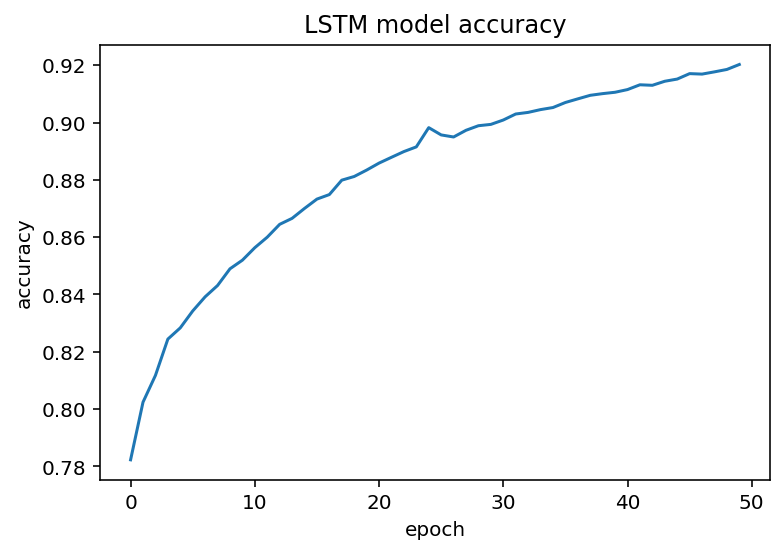

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

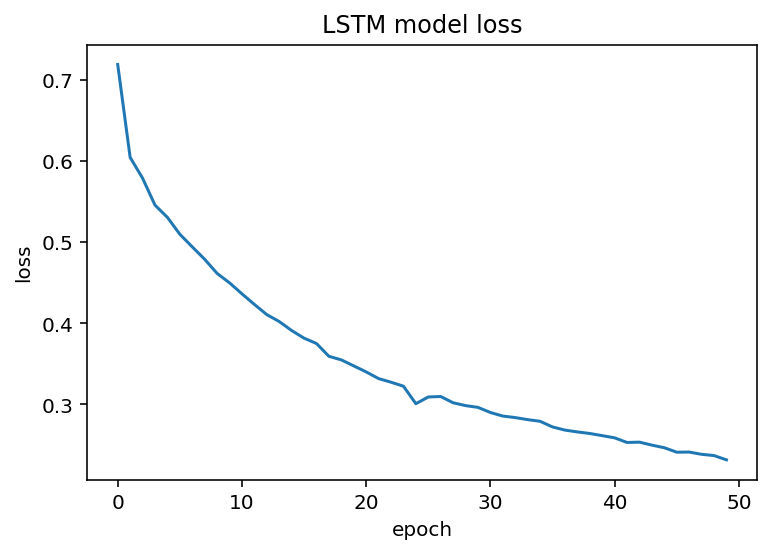

In [ ]:
plt.plot(history.history['loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# **Generate melodies w/ model**





In [ ]:
class MelodyGenerator:

  def __init__(self, model_path = os.path.join(code_path,"model.h5")):
    self.model_path = model_path
    self.model = keras.models.load_model(model_path)

    with open(MAPPING_PATH, "r") as fp:
      self._mappings = json.load(fp)
    
    self._start_symbols = ["/"] * SEQUENCE_LENGTH

  def _sample_with_temperature(self, probabilities, temperature):
    """
    temperature should be value between 0 & 1 (remodels probability distribution, if 1, we use original probability distribution
    closer to 0 is more creative/unpredictive sampling)
    """

    predictions = np.log(probabilities) / temperature #high temp == more homogenous distribution, low temp = more conservative
    probabilities = np.exp(predictions)/np.sum(np.exp(predictions)) #resample w/ softmax

    #sample value from remodelled distribution
    choices = range(len(probabilities))
    idx = np.random.choice(choices,p = probabilities)  #chooses an index from the possible notes keeping in mind prob. distribution

    return idx

  def generate(self, seed, num_steps, max_sequence_length, temperature):
    """
    - seeds are starter melodies (strings) for the model to continue, encoded numerically, input 5-15 starter notes
    - num_steps specifies how many steps/notes for the generator to attempt to produce (will break before this if end token generated)
    - max_sequence_length, specifies how far back in music time series model the model will consider when generating melody
    - temperature specifies sampling of output based on probabilitiy of symbols 
    """

    # prepend start symbols to seed
    seed = seed.split()
    melody = seed
    seed = self._start_symbols + seed 

    # encode seed melody as integers using mappings
    seed = [self._mappings[i] for i in seed]
    
    for _ in range(num_steps):

      # limit seeds to max_sequence length
      seed = seed[-max_sequence_length:]

      # one hot encode seed
      seed_enc = keras.utils.to_categorical(seed, num_classes=len(self._mappings))

      # predict method in keras expects 3 dimensions b/c expects a batch of samples, not just one. so we have to add an extra dimension
      # (1,max_sequence_length, mappings len)
      seed_enc = seed_enc[np.newaxis, ...]

      # predict melody from seed using model
      probabilities = self.model.predict(seed_enc)[0] #returns probability distribution

      # use temperature sampling to choose note value from the most probably in the distribution
      output_int = self._sample_with_temperature(probabilities,temperature)

      # append output of sampling to the seed
      seed.append(output_int)

      # convert output_int to encoding (mappings)
      output_symbol = [k for k,v in self._mappings.items() if v == output_int][0] #returns a single item, so take the 0th index

      # determine if end symbol ('/') has been generated, end generation if so
      if output_symbol == "/":
        print("END TOKEN DETECTED")
        break 

      # update melody if end token not generated
      melody.append(output_symbol)
    
    return melody

**seed generator**

Run these cells to load in the melody generator as well as the seed generation function.

In [ ]:
def create_seed(mappings,length):
  """
  Generate starter melody from complete random selection of vocabulary 
  """
  seed = []
  mappings = json.load(open(os.path.join(code_path,mappings)))
  mappings.pop("/",None) #remove end token
  keys = list(mappings.keys())
  for n in range(length):
    if n * random.randrange(20) % 2 == 0:
      seed.append(keys[random.randrange(len(keys))])
      for n in range(random.randrange(0,5)):
        seed.append("_")
    else:
      seed.append("_")
  return " ".join(map(str,seed))
generator = MelodyGenerator()

In [ ]:
seed = create_seed("vocabulary.json",1)
new_melody = generator.generate(seed, 500, SEQUENCE_LENGTH,0.5)
print(seed)
print("=== Generated melody ===")
print(" ".join(new_melody))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


END TOKEN DETECTED
58 _ _ _
=== Generated melody ===
58 _ _ _ _ _ _ _ 76 _ _ _ _ _ _ _ 77 _ _ _ 76 _ _ _ _ _ _ _ 74 _ _ _ 72 _ _ _ _ _ _ _ _ _ _ _ 71 _ _ _ _ _ _ _ r _ _ _ 72 _ _ _ 74 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 76 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ _ _ _ _ _ 69 _ _ _ _ _ _ _ 71 _ _ _ _ _ _ _ 69 _ _ _ _ _ _ _


## **Save Generated melodies in browser**

run this cell to load in save_melody function

In [ ]:
def save_melody(melody, step_duration = 0.25,format = "midi",file_name = "generated.midi"):
    
    # create a music21 stream, streams contain notes rests for a melody
    stream = m21.stream.Stream()  

    # parse symbols in melody
    start_symbol = None
    step_counter = 1

    for i,symbol in enumerate(melody):
      # notes/rest (event)

      if symbol != "_" or i + 1 == len(melody):
        # check if event is not first in duration
        if start_symbol != None:
          quarter_length_duration = step_duration * step_counter 

          #handle rest
          if start_symbol == "r":
            m21_event = m21.note.Rest(quarterLength = quarter_length_duration)

          #handle note
          else: 
            m21_event = m21.note.Note(int(start_symbol))

          stream.append(m21_event) 

          #reset step counter
          step_counter = 1
          #update start symbol
        start_symbol = symbol

      # prolongations "_"
      else:
        step_counter += 1
  
    # write m21 to midi file
    stream.write(format,file_name)
    stream.show('midi')

# Play melody in browser

In [ ]:
save_melody(seed.split(),file_name="seed.midi")
save_melody(new_melody)

In [ ]:
!fluidsynth -ni font.sf2 generated.midi -F output.wav -r 44100
from IPython.display import Audio
Audio('output.wav')

# Plot MIDi

In [ ]:
preset = Preset(plot_width=850)
plotter = Plotter(preset, plot_max_length_bar=4)

In [ ]:
sm = PrettyMIDI("seed.midi")
plotter.show_notebook(sm)

Column(id='1787', ...)

In [ ]:
pm = PrettyMIDI("generated.midi")
plotter.show_notebook(pm)

Column(id='2110', ...)